In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import numpy
import cv2
import tensorflow as tf
import cv2
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Flatten, Dense,Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomTranslation



2024-12-18 22:16:08.384849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 22:16:08.528123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:16:09.065278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yaser/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/yaser/miniconda3/envs/tf/lib/:/home/yaser/miniconda3/envs/tf/lib/
2024-12-18 22:16:09.066201: W tensorflow/stream_executor/platfor

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,
    subset="validation",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Testing",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)



Found 1912 files belonging to 2 classes.
Using 1530 files for training.


2024-12-18 22:16:11.827735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:16:11.837354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:16:11.837440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:16:11.838052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 1912 files belonging to 2 classes.
Using 382 files for validation.
Found 476 files belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = preprocess_input(image)  # Preprocess for VGG19
    return image, label
    

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
testing_dataset = testing_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)
# Load VGG16 model with pretrained weights, excluding the top (fully connected) layers
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Build the model
model = Sequential()
for layer in vgg19_model.layers:
  model.add(layer)
# Freeze the layers of VGG19 to retain the pre-trained weights
for layer in model.layers:
  layer.trainable = False # Not trainable weights

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore the weights of the best model
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['accuracy']
    
)

history = model.fit(train_dataset, validation_data=validation_dataset, batch_size= 64, epochs =7 ,callbacks=[early_stopping])

Epoch 1/7


2024-12-18 22:16:18.179270: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-12-18 22:16:19.098185: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:16:19.127715: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:16:19.127790: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-18 22:16:19.157896: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:16:19.158020: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-18 22:16:24.374236: W tensorflow/core/common_runtime/bf

23/24 [===========================>..] - ETA: 0s - loss: 0.5235 - accuracy: 0.7493

2024-12-18 22:16:40.900528: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-18 22:16:40.900794: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.86GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-18 22:16:41.055272: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-18 22:16:41.055345: W tensorflow/core/common_runtime/bfc_allocato

24/24 [==============================] - 47s 1s/step - loss: 0.5192 - accuracy: 0.7556 - val_loss: 0.3075 - val_accuracy: 0.9476
Epoch 2/7
24/24 [==============================] - 10s 394ms/step - loss: 0.3475 - accuracy: 0.8739 - val_loss: 0.1994 - val_accuracy: 0.9607
Epoch 3/7
24/24 [==============================] - 10s 395ms/step - loss: 0.2610 - accuracy: 0.9216 - val_loss: 0.1458 - val_accuracy: 0.9712
Epoch 4/7
24/24 [==============================] - 12s 485ms/step - loss: 0.2178 - accuracy: 0.9431 - val_loss: 0.1291 - val_accuracy: 0.9581
Epoch 5/7
24/24 [==============================] - 10s 394ms/step - loss: 0.1836 - accuracy: 0.9556 - val_loss: 0.1137 - val_accuracy: 0.9634
Epoch 6/7
24/24 [==============================] - 10s 393ms/step - loss: 0.1498 - accuracy: 0.9771 - val_loss: 0.1037 - val_accuracy: 0.9764
Epoch 7/7
24/24 [==============================] - 12s 487ms/step - loss: 0.1329 - accuracy: 0.9660 - val_loss: 0.1147 - val_accuracy: 0.9634


In [6]:
def bgr_to_rgb(image):
    # Convert BGR to RGB
    image = image[..., ::-1]  # Reverse the last axis (channels)
    
    # Normalize the image to [0, 255] by undoing preprocessing (scale and shift)
    image = (image + 128)  # Undo the VGG19 preprocessing (subtracting the mean)
    image = np.clip(image, 0, 255)  # Clip the values to ensure they are within the valid range for display
    return image

1/1 [==============================] - 5s 5s/step
Testing Accuracy: 97.06%


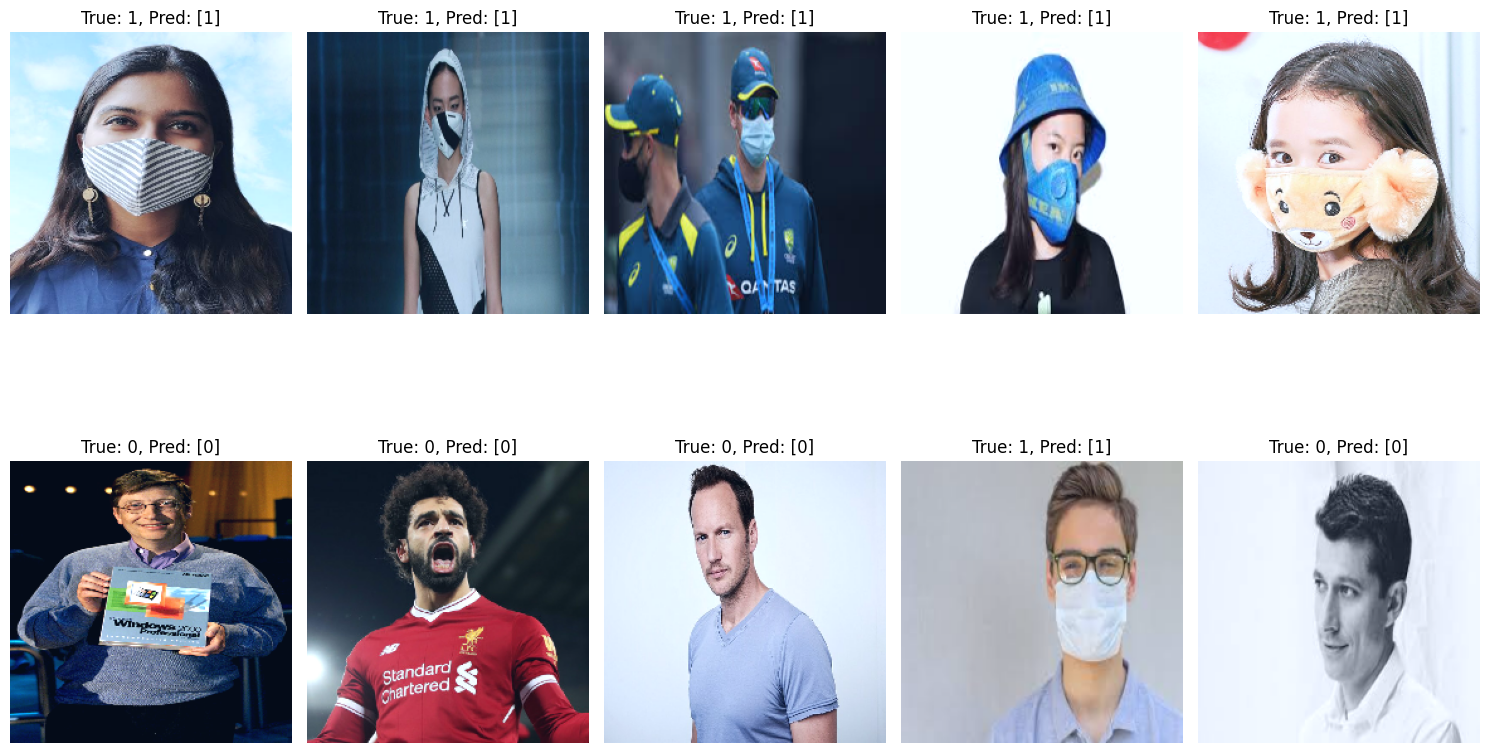

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize lists to store true labels, predicted labels, and images
true_labels = []
predicted_labels = []
images_batch = []

# Iterate through the testing dataset to collect the first 10 images
for images, labels in testing_dataset:
    # Append the images, true labels
    true_labels.append(labels.numpy())
    images_batch.append(images.numpy())
    
    # Get the model predictions (probabilities)
    predicted_probs = model.predict(images)
    
    # Convert the probabilities to predicted labels (0 or 1)
    predicted_labels_batch = (predicted_probs > 0.5).astype(int)
    predicted_labels.append(predicted_labels_batch)
    

# Flatten the lists of true labels, predicted labels, and images
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)
images_batch = np.concatenate(images_batch, axis=0)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")
# Show the first 10 images with their true and predicted labels
plt.figure(figsize=(15, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Arrange images in 2 rows and 5 columns
    rgb_image = bgr_to_rgb(images_batch[i])
    plt.imshow(rgb_image.astype(np.uint8))  # Display the image as uint8
    plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report: Precision, Recall, F1-Score
report = classification_report(true_labels, predicted_labels, target_names=["No Mask", "Mask"])
print("Classification Report:")
print(report)




Classification Report:
              precision    recall  f1-score   support

     No Mask       0.97      0.97      0.97       238
        Mask       0.97      0.97      0.97       238

    accuracy                           0.97       476
   macro avg       0.97      0.97      0.97       476
weighted avg       0.97      0.97      0.97       476



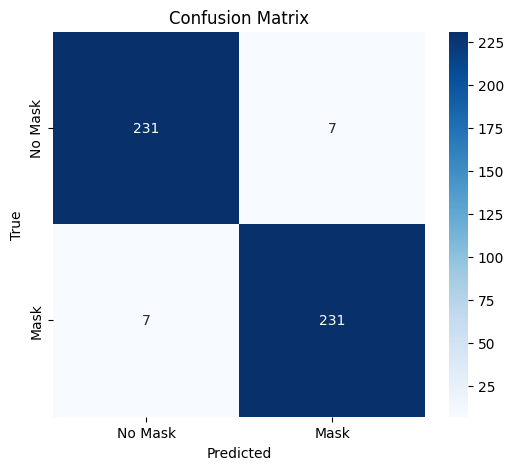

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
model.save("MaskClassification-VGG19.keras")

In [11]:
import pickle
# Save the history to a file
with open('MaskClassification-VGG19.pkl', 'wb') as file:
    pickle.dump(history, file)

INFO:tensorflow:Assets written to: ram://12a5265a-7281-419e-a446-d193f77d2067/assets


INFO:tensorflow:Assets written to: ram://12a5265a-7281-419e-a446-d193f77d2067/assets


In [12]:
import pickle
# Load the history from the file
with open('MaskClassification-VGG19.pkl', 'rb') as file:
    history = pickle.load(file)